In [1]:
import numpy as np
import pandas as pd
import os.path
from random import randint

# -*- coding: utf-8 -*-
"""
### NOTES
This file is an example of what your code should look like. It is written in Python 3.6.
To know more about the expectations, please refer to the guidelines.
"""

#####
# DATA IMPORT
#####

# Where data is located
movies_file = './data/movies.csv'
users_file = './data/users.csv'
ratings_file = './data/ratings.csv'
predictions_file = './data/predictions.csv'
submission_file = './data/submission.csv'

# Read the data using pandas
movies_description = pd.read_csv(movies_file, delimiter=';', dtype={'movieID': 'int', 'year': 'int', 'movie': 'str'},
                                 names=['movieID', 'year', 'movie'])
users_description = pd.read_csv(users_file, delimiter=';',
                                dtype={'userID': 'int', 'gender': 'str', 'age': 'int', 'profession': 'int'},
                                names=['userID', 'gender', 'age', 'profession'])
ratings_description = pd.read_csv(ratings_file, delimiter=';',
                                  dtype={'userID': 'int', 'movieID': 'int', 'rating': 'int'},
                                  names=['userID', 'movieID', 'rating'])
predictions_description = pd.read_csv(predictions_file, delimiter=';', names=['userID', 'movieID'], header=None)

utility_matrix: pd.DataFrame = \
        ratings_description.pivot(index='userID', columns='movieID', values='rating').T
utility_matrix

userID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movieID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,5.0,5.0,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
##### Construct Utility Matrix ####### 
R = np.zeros((len(movies_description), len(users_description)))

for user, movie, rating in ratings_description.values:
    R[movie-1, user-1] = rating

R[R==0] = np.nan
print(f"Shape of Utility matrix is (movies, users): {R.shape}")

Shape of Utility matrix is (movies, users): (3706, 6040)


In [7]:
#### LATENT FACTORS HYPERPARAMETERS ####
from tqdm import tqdm_notebook as tqdm

EPOCHS = 1000
LEARNING_RATE = 0.05 # == nu
K = 2 # number of factors to work with.

np.random.seed(42)
Q = np.random.uniform(-1, 1, (R.shape[0], K))
P = np.random.uniform(-1, 1, (K, R.shape[1]))
div = (R.shape[0] * R.shape[1]) - np.isnan(R).sum()
RMSE = np.sqrt(((np.nan_to_num(R - np.matmul(Q, P), 0)**2).sum())/div)
print(f"Starting RMSE: {RMSE}")

objectives = []

for epoch in tqdm(range(1000)):
    R_pred = np.matmul(Q,P)
    curr_error = np.nan_to_num(R - R_pred, 0)
    Q_update = np.zeros(Q.shape)
    for i in range(len(Q_update)):
        for curr_k in range(K):
            Q_delta =(-2 * np.dot(P[curr_k, :], curr_error[i]))/np.isnan(R[i]).sum()
            Q_update[i, curr_k] = LEARNING_RATE * Q_delta

    P_update = np.zeros(P.shape)
    for i in range(P_update.shape[1]):
        for curr_k in range(K):
            P_delta =(-2 * np.dot(Q[:, curr_k], curr_error[:, i]))/np.isnan(R[:, i]).sum()
            P_update[curr_k, i] = LEARNING_RATE * P_delta

    Q -= Q_update
    P -= P_update
    
    RMSE_i = np.sqrt(((np.nan_to_num(R - np.matmul(Q, P), 0)**2).sum())/div)
    objectives.append([epoch, RMSE_i])


RMSE = np.sqrt(((np.nan_to_num(R - np.matmul(Q, P), 0)**2).sum())/div)
print(f"Final RMSE: {RMSE}")

Starting RMSE: 3.781830053581588


<ipython-input-7-3fb91e8b325e>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(1000)):



Final RMSE: 0.927614548906496


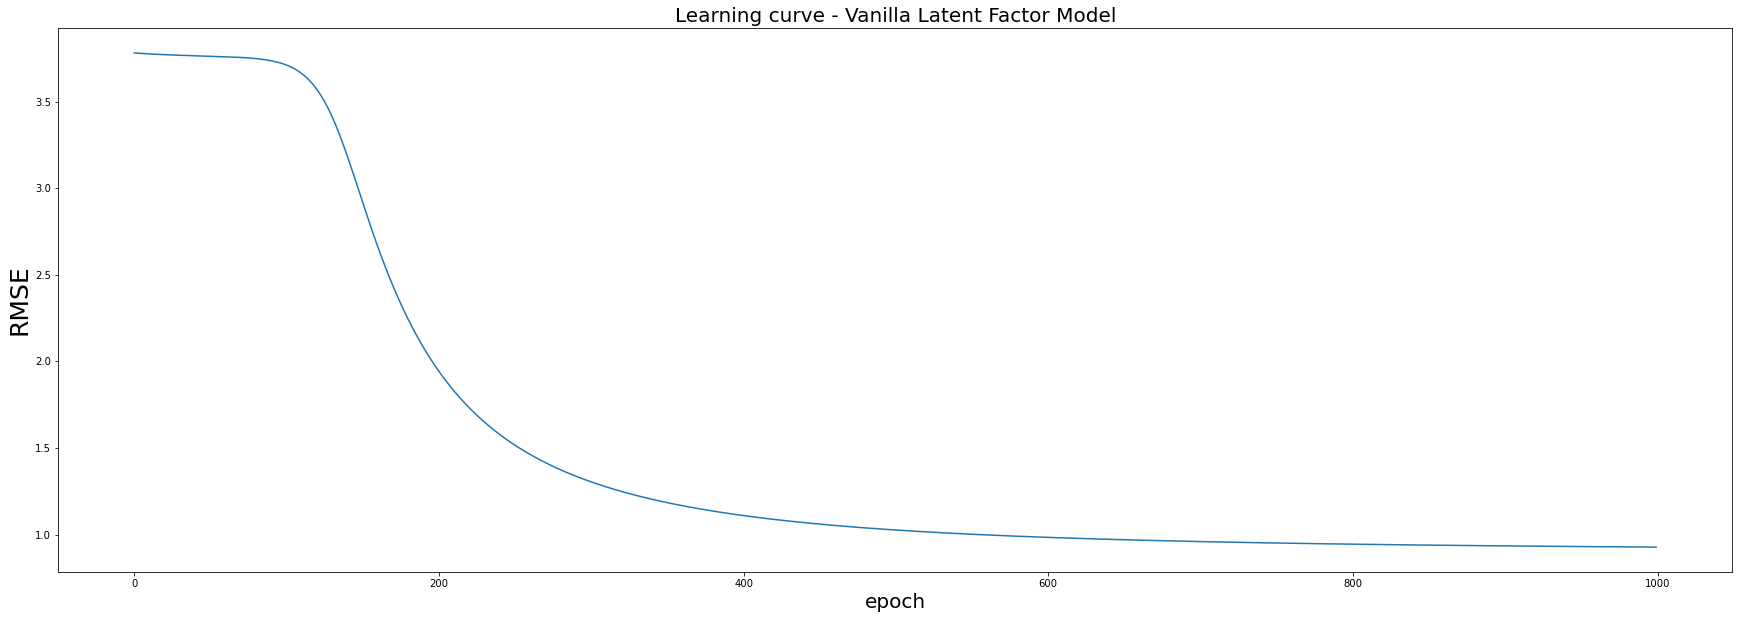

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 10))
plt.title("Learning curve - Vanilla Latent Factor Model", fontsize=20)
plt.xlabel("epoch", fontsize=20)
plt.ylabel("RMSE", fontsize=25)
plt.plot(np.array(objectives)[:, 1])
plt.savefig("figures/vanilla-latent-factor.png")

In [ ]:
#### LATENT FACTORS WITH REGULARIZATION ####
#### LATENT FACTORS HYPERPARAMETERS ####
from tqdm import tqdm_notebook as tqdm

EPOCHS = 1000
LEARNING_RATE = 0.05 # == nu
LAMBDA = 0.01
K = 2 # number of factors to work with.

np.random.seed(42)
Q = np.random.uniform(-1, 1, (R.shape[0], K))
P = np.random.uniform(-1, 1, (K, R.shape[1]))
div = (R.shape[0] * R.shape[1]) - np.isnan(R).sum()
RMSE = np.sqrt(((np.nan_to_num(R - np.matmul(Q, P), 0)**2).sum())/div)
print(f"Starting RMSE: {RMSE}")

objectives = []

for epoch in tqdm(range(1000)):
    R_pred = np.matmul(Q,P)
    curr_error = np.nan_to_num(R - R_pred, 0)
    Q_update = np.zeros(Q.shape)
    for i in range(len(Q_update)):
        for curr_k in range(K):
            Q_delta =(-2 * np.dot(P[curr_k, :], curr_error[i]))/np.isnan(R[i]).sum()
            Q_update[i, curr_k] = LEARNING_RATE * (Q_delta + LAMBDA*Q[i, curr_k])

    P_update = np.zeros(P.shape)
    for i in range(P_update.shape[1]):
        for curr_k in range(K):
            P_delta =(-2 * np.dot(Q[:, curr_k], curr_error[:, i]))/np.isnan(R[:, i]).sum()
            P_update[curr_k, i] = LEARNING_RATE * (P_delta + LAMBDA*P[curr_k, i])

    Q -= Q_update
    P -= P_update
    
    RMSE_i = np.sqrt(((np.nan_to_num(R - np.matmul(Q, P), 0)**2).sum())/div)
    print(f"RMSE {epoch}: {RMSE_i}")
    objectives.append([epoch, RMSE_i])


RMSE = np.sqrt(((np.nan_to_num(R - np.matmul(Q, P), 0)**2).sum())/div)
print(f"Final RMSE: {RMSE}")

Starting RMSE: 3.781830053581588


<ipython-input-16-3f46e573ee58>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(1000)):


RMSE 0: 3.7810569863061056
RMSE 1: 3.7803143482127624
RMSE 2: 3.779600254864564
RMSE 3: 3.7789129704709286
RMSE 4: 3.778250893695214
RMSE 5: 3.777612544956513
RMSE 6: 3.7769965550515123
RMSE 7: 3.7764016549438972
RMSE 8: 3.775826666587716
RMSE 9: 3.7752704946672684
RMSE 10: 3.7747321191502476
RMSE 11: 3.7742105885634096
RMSE 12: 3.7737050139101416
RMSE 13: 3.7732145631594074
RMSE 14: 3.7727384562430437
RMSE 15: 3.7722759605057528
RMSE 16: 3.7718263865583967
RMSE 17: 3.7713890844906053
RMSE 18: 3.770963440403323
RMSE 19: 3.770548873226374
RMSE 20: 3.7701448317896378
RMSE 21: 3.7697507921195914
RMSE 22: 3.769366254935952
RMSE 23: 3.7689907433255794
RMSE 24: 3.7686238005728576
RMSE 25: 3.7682649881278585
RMSE 26: 3.7679138836952064
RMSE 27: 3.767570079427781
RMSE 28: 3.767233180211209
RMSE 29: 3.7669028020254043
RMSE 30: 3.7665785703712467
RMSE 31: 3.766260118750528
RMSE 32: 3.765947087188441
RMSE 33: 3.7656391207883746
RMSE 34: 3.7653358683090308
RMSE 35: 3.7650369807546875
RMSE 36: 3.76

In [6]:
#### CREATE SUBMISSION ####
submission = []
for i, [user,movie] in enumerate(predictions_description.values):
    submission.append([i+1, R_pred[movie-1,user-1]])

submission_df = pd.DataFrame(submission, columns=["Id", "# Rating"])
submission_df.to_csv("data/submission.csv", index=False)

[[1, 3.474430655182154],
 [2, 2.261235162482041],
 [3, 3.5400326311644896],
 [4, 4.092255007716797],
 [5, 3.0139332735093665],
 [6, 1.6816272485662942],
 [7, 3.959154112699957],
 [8, 4.2130823613515345],
 [9, 3.3925228566412367],
 [10, 4.3078897450218125]]